<a href="https://colab.research.google.com/github/felipemontano10/DeepLearning/blob/master/PS3_JFelipeMontanoCampos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECE 685D - Fall 2020
## Problem Set 3 

> J. Felipe Montano-Campos

**Problem 3: Binary Classification with Generalized Linear Models**


In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.linalg import inv
from sklearn import preprocessing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving breast_cancer.csv to breast_cancer.csv


In [3]:
#Data Preparation 
cancer_data = pd.read_csv("breast_cancer.csv") 

targets = cancer_data["diagnosis"]
targets = targets.replace({"B": 0, "M": 1})

features = ['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se']

features_df = cancer_data[features]

X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.3, random_state=40)




**Discriminant Analysis**

In [5]:
##Discriminant Analysis

def discriminant_binary(X_train, y_train, X_test, y_test):
    train = pd.concat([X_train, y_train], axis=1, sort=False)
    sigma =  np.cov(X_train.T)
    sigma_inv = inv(sigma)
    mu_1 = train.loc[train["diagnosis"]==1].mean() 
    mu_2 = train.loc[train["diagnosis"]==0].mean()
    mu_1 = np.array(mu_1.drop(index = "diagnosis"))
    mu_2 = np.array(mu_2.drop(index = "diagnosis"))
    p_c1 = np.mean(np.array(train["diagnosis"]))
    p_c2 = 1-p_c1
    w = np.matmul(sigma_inv,(mu_1-mu_2))
    w_0 = -0.5*np.matmul(np.matmul(mu_1.T,sigma_inv),mu_1)+ 0.5*np.matmul(np.matmul(mu_2.T,sigma_inv),mu_2)+np.log(p_c1/p_c2)
    train_pred = w_0 + np.matmul(np.array(X_train),w)
    train_pred[train_pred > 0] =1
    train_pred[train_pred < 0] = 0
    correct_train = (train_pred == y_train)
    accuracy_train = correct_train.sum() / correct_train.size
    test_pred = w_0 + np.matmul(np.array(X_test),w)
    test_pred[test_pred > 0] =1
    test_pred[test_pred < 0] = 0
    correct_test = (test_pred == y_test)    
    accuracy_test = correct_test.sum() / correct_test.size
    
    return (accuracy_test, accuracy_train)

In [7]:
train_acc, test_acc = discriminant_binary(X_train, y_train, X_test, y_test)
print("Training Accuracy:"+str(train_acc)) 
print("Test Accuracy:"+str(test_acc)) 

Training Accuracy:0.935672514619883
Test Accuracy:0.8944723618090452


**Logistic Regression**

In [8]:
#Import Packages
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#Pre Process Data
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [10]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out


n_epochs = 50
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_classes = y_train.value_counts().shape[0]
learning_rate = 0.1

In [11]:
#Define the Logistic Regression Function to train the model

def LR(X_train, y_train, X_test, y_test, n_epochs, n_features,n_classes,learning_rate):
    X, y = torch.from_numpy(np.array(X_train)).float(), torch.from_numpy(np.array(y_train)).long()
    Xtest, ytest = torch.from_numpy(np.array(X_test)).float(), torch.from_numpy(np.array(y_test)).long()    
    model = LogisticRegressionModel(n_features, n_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate) # Experiment to see the senstivity of learning rate with SGD
    criterion = nn.CrossEntropyLoss()
    # Train
    model.train('True')
    loss_train = []
    loss_test = []
    train_list = []
    test_list = []
    for epoch in range(n_epochs):
        print("Epoch number:"+str(epoch))        
        y_hat = model(X)
        loss = criterion(y_hat.squeeze(), y)
        optimizer.zero_grad()
        loss.backward() # Backward Pass
        optimizer.step()
        loss_train.append(loss.item())
        #Training Accuracy
        _, predicted = torch.max(y_hat.data,1)
        correct = (predicted == y) 
        accuracy = int(correct.sum()) / correct.shape[0]
        print("Training Accuracy")
        print(accuracy)
        train_list.append(accuracy)
        #Test Accuracy
        y_hat_test = model(Xtest)     
        losstest = criterion(y_hat_test.squeeze(), ytest)
        loss_test.append(losstest.item())
        _, predicted_test = torch.max(y_hat_test.data,1)
        correct_test = (predicted_test == ytest)    
        accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
        print("Test Accuracy")
        print(accuracy_test)
        test_list.append(accuracy_test)
    return (loss_train, loss_test ,train_list,test_list)


In [12]:
loss_train, loss_test, train_list, test_list = LR(X_train, y_train, X_test, y_test, n_epochs, n_features,n_classes,learning_rate)


Epoch number:0
Training Accuracy
0.42462311557788945
Test Accuracy
0.52046783625731
Epoch number:1
Training Accuracy
0.4849246231155779
Test Accuracy
0.5789473684210527
Epoch number:2
Training Accuracy
0.5603015075376885
Test Accuracy
0.6491228070175439
Epoch number:3
Training Accuracy
0.6633165829145728
Test Accuracy
0.7134502923976608
Epoch number:4
Training Accuracy
0.6859296482412061
Test Accuracy
0.7309941520467836
Epoch number:5
Training Accuracy
0.7261306532663316
Test Accuracy
0.7719298245614035
Epoch number:6
Training Accuracy
0.7562814070351759
Test Accuracy
0.7719298245614035
Epoch number:7
Training Accuracy
0.7889447236180904
Test Accuracy
0.8128654970760234
Epoch number:8
Training Accuracy
0.8165829145728644
Test Accuracy
0.8304093567251462
Epoch number:9
Training Accuracy
0.8391959798994975
Test Accuracy
0.8304093567251462
Epoch number:10
Training Accuracy
0.8567839195979899
Test Accuracy
0.847953216374269
Epoch number:11
Training Accuracy
0.8693467336683417
Test Accuracy

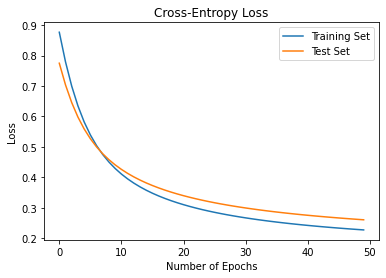

In [13]:
##Plot losses

plt.plot(list(range(n_epochs)),loss_train, label = "Training Set" )
plt.plot(list(range(n_epochs)),loss_test, label = "Test Set" )
plt.title('Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper right')
plt.show()

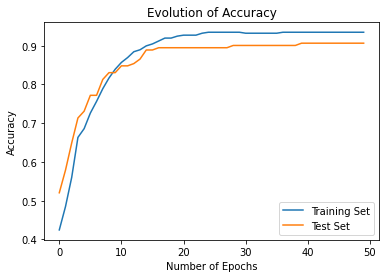

In [14]:

#Plot Accuracy
plt.plot(list(range(n_epochs)),train_list, label = "Training Set" )
plt.plot(list(range(n_epochs)),test_list, label = "Test Set" )
plt.title('Evolution of Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc='lower right')
plt.show()

**Problem 5: First-order Optimization Methods**

In [15]:
import scipy
import scipy.io



In [16]:
from google.colab import files
uploaded = files.upload()

Saving mnist-original.mat to mnist-original.mat


In [9]:
#import Data
mnist_data = scipy.io.loadmat('mnist-original.mat')
X = mnist_data['data'].T
y = mnist_data['label'].T
#Pre process
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
#Train and test set
train_dataset, test_dataset, train_labels, test_labels = train_test_split(X, y, test_size=1/7, random_state=671)
train_labels = pd.get_dummies(pd.DataFrame(train_labels)[0], prefix='numb')
test_labels = pd.get_dummies(pd.DataFrame(test_labels)[0], prefix='numb')
print (train_dataset.shape, train_labels.shape)
print (test_dataset.shape, test_labels.shape)
#Get everything in np.array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
#Use Pytorch
X, y = torch.from_numpy(np.array(train_dataset)).float(), torch.from_numpy(np.array(train_labels)).long()
Xtest, ytest = torch.from_numpy(np.array(test_dataset)).float(), torch.from_numpy(np.array(test_labels)).long()


In [ ]:
#Define logistic regression
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out

**Momentum Method**

**Fit a GMM to the data generated**

In [ ]:
from sklearn import mixture

K = [1,2,3,4,5,6,7]

likelihood = []
for k in K:
    gmm = mixture.GaussianMixture(n_components=k, max_iter=1000, covariance_type='full').fit(data_set)
    score = gmm.score(data_set)
    likelihood.append(score)

**Plot of the Log-Likelihood Function**

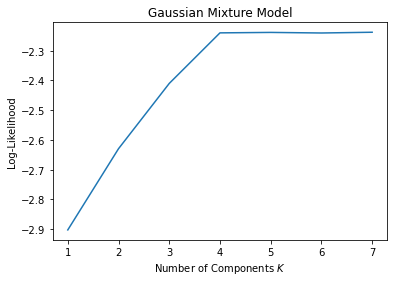

In [ ]:
plt.plot(K, likelihood)
plt.title('Gaussian Mixture Model')
plt.xlabel('Number of Components $K$')
plt.ylabel('Log-Likelihood')
plt.show()

**Problem 3: Bayesian linear regression**

**a) and b) Please look at the pdf file** 

**c) Plot the contour of prior and posterior distributions**

In [ ]:
import numpy as np
from numpy.linalg import inv

def sum_norm(N,mu,var):
    data = np.array([0,0])
    data = np.expand_dims(data, axis=0)
    for i in list(range(N)):
        array = np.random.multivariate_normal(mu, var)
        array = np.expand_dims(array,axis=0)
        data = np.append(data,array,axis=0)
        value = data.sum(axis=0)
    return value  

**Set up the values of the parameters**

In [ ]:
N = 10
mu_0 = np.array([0.5, 0.5])
sigma_0 = np.array([[0.1,0],[0,0.1]])
x = np.array([1.5,1.5])
sigma_y = np.array([[0.2,0.1],[0.1,0.1]])
sigma_inv = inv(sigma_0)+N*inv(sigma_y)
mu = np.dot(np.dot(inv(sigma_inv),inv(sigma_0)),mu_0)+ np.dot(np.dot(inv(sigma_inv),inv(sigma_y)),sum_norm(N,x,sigma_y))
sigma = inv(sigma_inv)

**Contour of the prior**

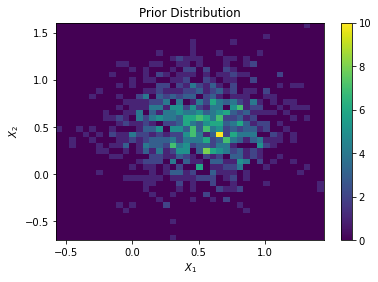

In [ ]:
import matplotlib.pyplot as plt 
prior = np.random.multivariate_normal(mu_0,sigma_0,10**3)
plt.hist2d(prior[:,0],prior[:,1], bins=40)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.title("Prior Distribution") 
plt.colorbar()
plt.show()  

**Contour of the posterior**

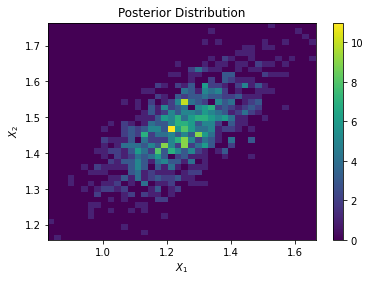

In [ ]:
posterior = np.random.multivariate_normal(mu,sigma,10**3)
plt.hist2d(posterior[:,0],posterior[:,1], bins=40)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.title("Posterior Distribution") 
plt.colorbar()
plt.show()  

**d) Plot the contour of the prior and posterior distribution**

**Set up the value of the parameters**

In [ ]:
N = 10
mu_0 = np.array([0.5, 0.5])
sigma_0 = np.array([[10,0],[0,10]])
x = np.array([1.5,1.5])
sigma_y = np.array([[0.2,0.1],[0.1,0.1]])
sigma_inv = inv(sigma_0)+N*inv(sigma_y)
mu = np.dot(np.dot(inv(sigma_inv),inv(sigma_0)),mu_0)+ np.dot(np.dot(inv(sigma_inv),inv(sigma_y)),sum_norm(N,x,sigma_y))
sigma = inv(sigma_inv)


**Contour of the Prior**

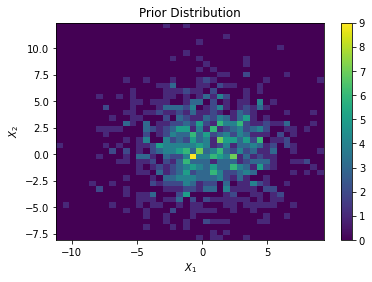

In [ ]:
prior = np.random.multivariate_normal(mu_0,sigma_0,10**3)
plt.hist2d(prior[:,0],prior[:,1], bins=40)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.title("Prior Distribution") 
plt.colorbar()
plt.show() 


**Countour of the Posterior**

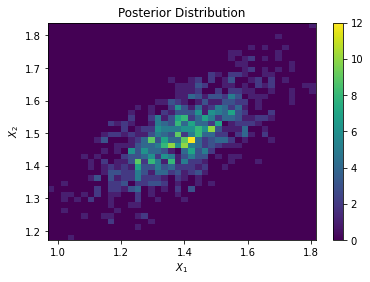

In [ ]:
posterior = np.random.multivariate_normal(mu,sigma,10**3)
plt.hist2d(posterior[:,0],posterior[:,1], bins=40)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.title("Posterior Distribution") 
plt.colorbar()
plt.show() 

**Set up the value of the parameters**

In [ ]:
N = 100
mu_0 = np.array([0.5, 0.5])
sigma_0 = np.array([[0.1,0],[0,0.1]])
x = np.array([1.5,1.5])
sigma_y = np.array([[0.2,0.1],[0.1,0.1]])

sigma_inv = inv(sigma_0)+N*inv(sigma_y)
mu = np.dot(np.dot(inv(sigma_inv),inv(sigma_0)),mu_0)+ np.dot(np.dot(inv(sigma_inv),inv(sigma_y)),sum_norm(N,x,sigma_y))
sigma = inv(sigma_inv)

**Contour of the Prior**

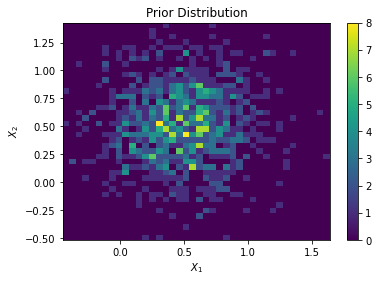

In [ ]:
prior = np.random.multivariate_normal(mu_0,sigma_0,10**3)
plt.hist2d(prior[:,0],prior[:,1], bins=40)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.title("Prior Distribution") 
plt.colorbar()
plt.show() 

**Countour of the Posterior**

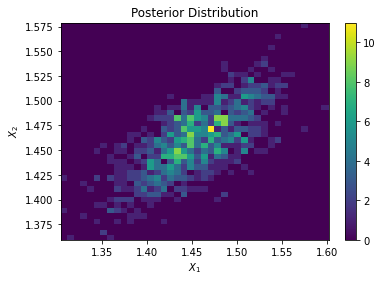

In [ ]:
posterior = np.random.multivariate_normal(mu,sigma,10**3)
plt.hist2d(posterior[:,0],posterior[:,1], bins=40)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.title("Posterior Distribution") 
plt.colorbar()
plt.show() 

**e) Conclusion from part d**

We can obseve that if we increase the variance of the prior, the variance of the posterior also increase and the precision of our estimates are less accurate. On the other hand, keeping the variance of the prior equal, as $N$ increases we can observe that the precision of our estimates is better (i.e., the variance of the posterior decreases). This result is intuitive since the more sensors we have, the better we can estimate the location of the object.  

**Problem 4: Bias-variance trade- off**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


**Create the training and test set**

In [ ]:
training = np.linspace(0, 0.8, 5)
labels  =  np.sin(2*np.pi*training) + np.cos(4*np.pi*training)
test = np.linspace(0,0.99,100)
labels_test  =  np.sin(2*np.pi*test) + np.cos(4*np.pi*test)
M = np.linspace(0,15,16)

**Calculate the SSE for the $M$ polynomials models**

In [ ]:
sqrt_errors_train = []
sqrt_errors_test = []

for i in M:
    error_train = np.sum((np.polyval(np.polyfit(training, labels, i), training) - labels)**2)
    error_test = np.sum((np.polyval(np.polyfit(training, labels, i), test) - labels_test)**2)
    sqrt_errors_train.append(error_train)
    sqrt_errors_test.append(error_test)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly co

**Plot for the training and test set**

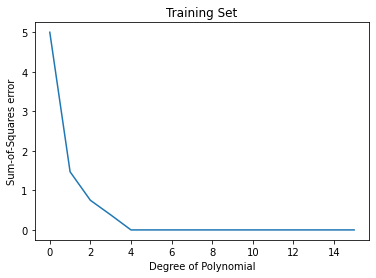

In [ ]:
plt.plot(M, sqrt_errors_train)
plt.title('Training Set')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Sum-of-Squares error')
plt.show()

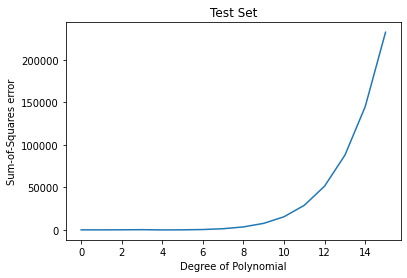

In [ ]:
plt.plot(M, sqrt_errors_test)
plt.title('Test Set')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Sum-of-Squares error')
plt.show()

**$L_{2}$ Regularization Penalty**

In [ ]:
lambda_values = np.linspace(10**-2, 50, 5000)
lambda_values_ln = np.log(lambda_values)

training_matrix = []
for i in list(range(1,15)):
    training_matrix.append(np.power(training,i))
training_matrix = np.array(training_matrix)
training_matrix = training_matrix.transpose()

test_matrix = []
for i in list(range(1,15)):
    test_matrix.append(np.power(test,i))
test_matrix = np.array(test_matrix)
test_matrix = test_matrix.transpose()


In [ ]:
from sklearn.linear_model import Ridge

sqrt_errors_train_lasso = []
sqrt_errors_test_lasso = []


for lamb in lambda_values:
    clf = Ridge(alpha= lamb)
    clf.fit(training_matrix, labels)
    train_predict = clf.predict(training_matrix)
    test_predict = clf.predict(test_matrix)
    error_train = np.sum((train_predict - labels)**2)
    error_test = np.sum((test_predict - labels_test)**2)
    sqrt_errors_train_lasso.append(error_train)
    sqrt_errors_test_lasso.append(error_test)  

**Plot for the training and test set**

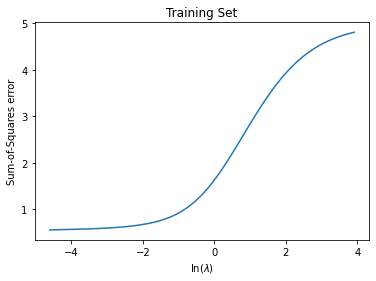

In [ ]:
plt.plot(lambda_values_ln,sqrt_errors_train_lasso )
plt.title('Training Set')
plt.xlabel(r'ln$(\lambda)$')
plt.ylabel('Sum-of-Squares error')
plt.show()

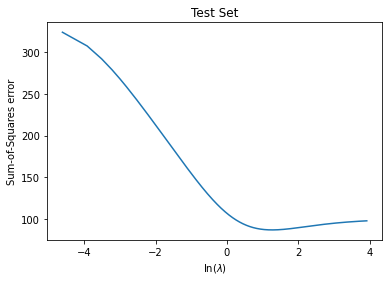

In [ ]:
plt.plot(lambda_values_ln, sqrt_errors_test_lasso)
plt.title('Test Set')
plt.xlabel(r'ln$(\lambda)$')
plt.ylabel('Sum-of-Squares error')
plt.show()



**Problem 5: Minimizing Minkowski Loss**

Please see the pdf.

**Problem 6: Nonlinear Basis Functions**

**Create the data sets**

In [ ]:
import numpy as np
from random import choices

#GMM1
gmm_1 = {}
gmm_1["mu"] = np.array([0,0])
gmm_1["cov"] = np.array([[0.1 , 0], [0 ,0.1]])

gmm1 = np.random.multivariate_normal(gmm_1["mu"], gmm_1["cov"], 100)    


#GMM2
gaussian_dist = np.array([1,2])
mix_coeff = np.array([1/2, 1/2])

gmm_2 = {}
gmm_2["mu_1"] = np.array([-1,-1])
gmm_2["mu_2"] = np.array([1,1])
gmm_2["cov_1"] = np.array([[0.1 , 0], [0 ,0.1]])
gmm_2["cov_2"] = np.array([[0.1 , 0], [0 ,0.1]])

gmm2 = np.array([0,0])
gmm2 = np.expand_dims(gmm2, axis=0)
for i in list(range(200)):
    choice = choices(gaussian_dist, mix_coeff)[0]
    array = np.random.multivariate_normal(gmm_2["mu_"+str(choice)], gmm_2["cov_"+str(choice)])    
    array = np.expand_dims(array, axis=0)
    gmm2 = np.append(gmm2, array, axis = 0)

gmm2 = np.delete(gmm2,0, axis=0)

**Plot the two data sets**

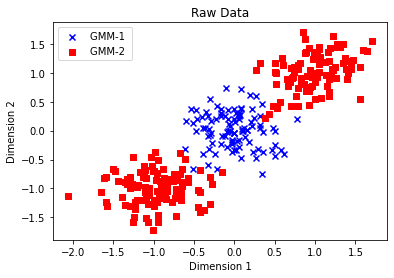

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(gmm1[:,0],gmm1[:,1], c='b', marker='x', label='GMM-1 ')
plt.scatter(gmm2[:,0],gmm2[:,1], c='r', marker='s', label='GMM-2 ')
plt.title("Raw Data")
plt.legend(loc='upper left')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

As we can see we can not find a single line that separates the two data sets.

**Transform the value of our features using the Gaussian basis functions**

In [ ]:
def gaussian_basis(x,mu):
    output = []
    iterations = x.shape[0]
    for i in list(range(iterations)):
        phi = np.exp(-0.5*np.dot(x[i,:]-mu,x[i,:]-mu))
        output.append(phi)
    return output

gmm1_transformed = np.column_stack((gaussian_basis(gmm1,gmm_1["mu"]),gaussian_basis(gmm1,gmm_2["mu_1"])))        
gmm2_transformed = np.column_stack((gaussian_basis(gmm2,gmm_1["mu"]),gaussian_basis(gmm2,gmm_2["mu_1"]))) 

**Plot the transformed data**

As we can clearly see, the transformed data is "more" separable since the red squares and the blue crosses are more segregated.